In [1]:
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
import cv2
import os
import pandas as pd

### Steering angle distrubution 
First we load the log file with the steering angles

In [2]:
dataDIR = './data'
logFile = os.path.join(dataDIR, 'driving_log.csv')
raw_data=pd.read_csv(logFile)
print('Number of images per camera in the log file : {}'.format(raw_data.shape[0]))
raw_data.head(5)

Number of images per camera in the log file : 1197


center  \
0  IMG/center_2017_03_17_16_01_05_323.jpg   
1  IMG/center_2017_03_17_16_01_05_405.jpg   
2  IMG/center_2017_03_17_16_01_05_486.jpg   
3  IMG/center_2017_03_17_16_01_05_567.jpg   
4  IMG/center_2017_03_17_16_01_05_648.jpg   

                                   left  \
0  IMG/left_2017_03_17_16_01_05_323.jpg   
1  IMG/left_2017_03_17_16_01_05_405.jpg   
2  IMG/left_2017_03_17_16_01_05_486.jpg   
3  IMG/left_2017_03_17_16_01_05_567.jpg   
4  IMG/left_2017_03_17_16_01_05_648.jpg   

                                   right  steering  throttle  brake  \
0  IMG/right_2017_03_17_16_01_05_323.jpg       0.0       0.0      0   
1  IMG/right_2017_03_17_16_01_05_405.jpg       0.0       0.0      0   
2  IMG/right_2017_03_17_16_01_05_486.jpg       0.0       0.0      0   
3  IMG/right_2017_03_17_16_01_05_567.jpg       0.0       0.0      0   
4  IMG/right_2017_03_17_16_01_05_648.jpg       0.0       0.0      0   

          speed  
0  2.540000e-07  
1  2.190000e-06  
2  6.340000e-06  
3  7.160000e-06  
4  4.030000e-06

In [3]:
raw_data['steering'].describe()

count    1197.000000
mean       -0.037444
std         0.128362
min        -0.716264
25%         0.000000
50%         0.000000
75%         0.000000
max         0.956795
Name: steering, dtype: float64

It is pretty obvious that data is skewed towards small steering angles. Below we plot the histogram on linear scale (left plot) and log scale (right plot) to confirm this observation. 

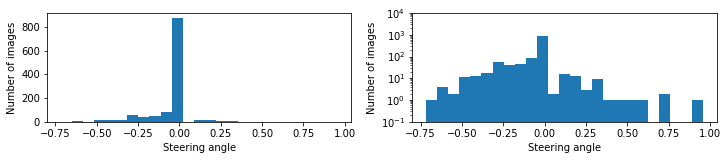

In [4]:
fig, axes = plt.subplots(1,2,figsize=(12,2))
for ax in axes :
    ax.hist(raw_data['steering'],bins=25)
    ax.set_xlabel('Steering angle')
    ax.set_ylabel('Number of images')
axes[1].set_ylim([0.1,10000])
axes[1].set_yscale('log')

Below we check if the images in the data are actually consistent with the information in the log file : 

In [5]:
left_imgFiles = glob(os.path.join(dataDIR,'IMG/left*.jpg'))
center_imgFiles = glob(os.path.join(dataDIR,'IMG/center*.jpg'))
right_imgFiles = glob(os.path.join(dataDIR,'IMG/right*.jpg'))


# check if every shot has all three camera angles and no images are missing
for centerFile in center_imgFiles :
    base_path, img_index = centerFile.split('center_')
    leftFile = os.path.join(base_path, 'left_'+img_index)
    rightFile = os.path.join(base_path, 'right_'+img_index)
    assert leftFile in left_imgFiles , leftFile+' mising'
    assert rightFile in right_imgFiles , rightFile+' mising'
print("All shots have three camera angles.")

nb_imgs = len(center_imgFiles)
print('{} images in the image dataset for each camera angle'.format(nb_imgs))

assert nb_imgs == raw_data.shape[0] , 'Number of images do not match with that in log file'
print('Number of images consistent with log file')

# get sample image size 
img = cv2.imread(center_imgFiles[0])
print('Size of a sample image is : {}'.format(img.shape))

All shots have three camera angles.
1197 images in the image dataset for each camera angle
Number of images consistent with log file
Size of a sample image is : (160, 320, 3)


### Data visualization

Below we display three random images from each of the three camera angles

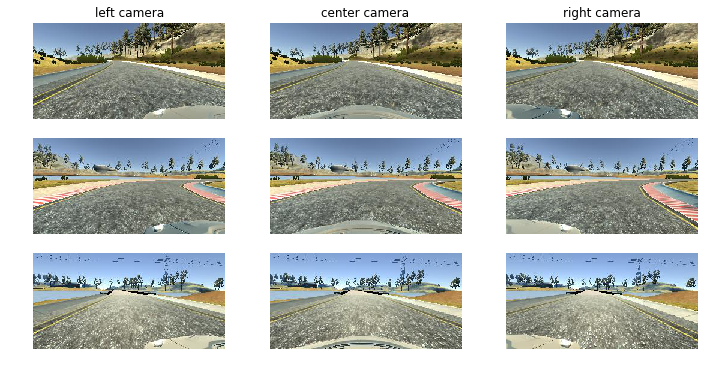

In [6]:
cam_positions = ['left','center','right']

class generate_image :
    def __init__(self, img_index, cam_pos='center') :
        self.img_data = raw_data.iloc[img_index]
        self.steer = self.img_data['steering']
        file_name = os.path.join(dataDIR,self.img_data[cam_pos].strip())
        img = cv2.imread(file_name)
        self.image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


# display random images for different camera angles
fig, axes = plt.subplots(3, 3, figsize=(12,6))
for pos,ax in zip(cam_positions, axes[0,:]):
    ax.set_title(pos+' camera')
for ax in axes :
    img_index = random.randrange(nb_imgs)
    for a, pos in zip(ax, cam_positions) :
        img = generate_image(img_index, cam_pos=pos)
        a.imshow(img.image)
        a.axis('off')

### Data cleaning 

Extreme steering angles can negatively effect training in the later stages, so we want to make sure these are genuines cases. Below we plot these outliers : 

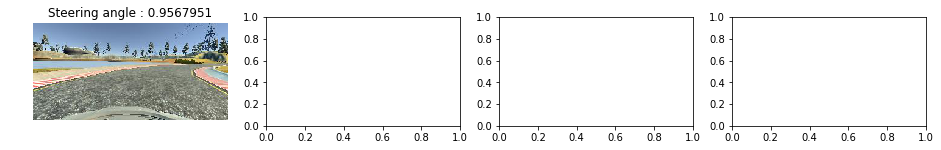

In [7]:
# visualize extreme steering angles
extreme_angles = raw_data.loc[(raw_data['steering']<-0.75) | (raw_data['steering']>0.75)].index

ncols = 4
nrows = int(np.ceil(len(extreme_angles)/ncols))
fig, axes = plt.subplots(nrows,ncols, figsize=(4*ncols,2*nrows))
for ax,img_index in zip(axes.flatten(), extreme_angles) :
    img = generate_image(img_index)
    ax.imshow(img.image)
    ax.set_title('Steering angle : '+str(img.steer))
    ax.axis('off')

In the above image, car seems to be fairly in the center of the road while steering angles look suspiciously high. Therefore, we pad the steering angle to -0.75  :  

In [8]:
# remove unnecessary info
data = raw_data
data = data.drop(['throttle','speed','brake'], axis=1)

# pad extreme steering angles
for i in extreme_angles[0:3] :
    data.loc[i,'steering'] = -0.75

nb_imgs = data.shape[0]
print('Number of images in dataset: {}'.format(nb_imgs))
data.describe()

Number of images in dataset: 1197


steering
count  1197.000000
mean     -0.038870
std       0.126779
min      -0.750000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.738370

One final step is to bin the images according to steering angles. We will use this binning later to remove bias towards low steering angles in the dataset. The selection probability of bins is determined by Gaussian distribution as shown below :  

In [9]:
from scipy.stats import norm 

nb_steer_bins = 25
steer_bins = np.linspace(-1.,1.001,nb_steer_bins+1)
steer_bin_index = list(range(1,nb_steer_bins+1))
data_bin_index = np.digitize(data['steering'], steer_bins) 
assert len(data_bin_index)==nb_imgs, "Check bins."

# selection probability for each bin
steer_bin_prob = np.array([norm.pdf(x, scale=.8) for x in steer_bins])
steer_bin_prob = {i:steer_bin_prob[i-1]/np.sum(steer_bin_prob) for i in steer_bin_index} 

# selection probability for each image 
img_prob = np.zeros(nb_imgs)

data_steer_bins = {steer_bin : [] for steer_bin in steer_bin_index}
for i in range(nb_imgs) :
    key = data_bin_index[i]
    data_steer_bins[key].append(i)

sum = 0
for index in steer_bin_index :
    bin_size = len(data_steer_bins[index])
    p_bin = steer_bin_prob[index]
    print("bin {:2} : {: .2f} < steering angle < {: .2f} : size = {:4} images :  selection probability = {:.3f}"
          .format(index, steer_bins[index-1], steer_bins[index], bin_size, p_bin))
    sum += bin_size
    for i in data_steer_bins[index] :
        img_prob[i] = p_bin/bin_size
print("Total images : {}".format(sum))

bin  1 : -1.00 < steering angle < -0.92 : size =    0 images :  selection probability = 0.023
bin  2 : -0.92 < steering angle < -0.84 : size =    0 images :  selection probability = 0.026
bin  3 : -0.84 < steering angle < -0.76 : size =    0 images :  selection probability = 0.029
bin  4 : -0.76 < steering angle < -0.68 : size =    2 images :  selection probability = 0.032
bin  5 : -0.68 < steering angle < -0.60 : size =    3 images :  selection probability = 0.034
bin  6 : -0.60 < steering angle < -0.52 : size =    3 images :  selection probability = 0.037
bin  7 : -0.52 < steering angle < -0.44 : size =   12 images :  selection probability = 0.040
bin  8 : -0.44 < steering angle < -0.36 : size =   16 images :  selection probability = 0.043
bin  9 : -0.36 < steering angle < -0.28 : size =   35 images :  selection probability = 0.045
bin 10 : -0.28 < steering angle < -0.20 : size =   69 images :  selection probability = 0.047
bin 11 : -0.20 < steering angle < -0.12 : size =   49 images

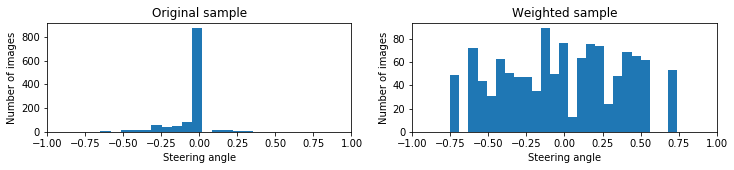

In [10]:
sum_wt = np.sum(img_prob)
fig, axes = plt.subplots(1,2,figsize=(12,2))
axes[0].hist(raw_data['steering'],bins=25)
axes[1].hist(data['steering'], bins=25, weights=[nb_imgs*img_prob[i]/sum_wt for i in range(nb_imgs)])
for ax in axes :
    ax.set_xlabel('Steering angle')
    ax.set_ylabel('Number of images')
    ax.set_xlim([-1,1])
axes[0].set_title('Original sample')
axes[1].set_title('Weighted sample')

### Image preprocessing

We will apply following steps for image preprocessing :
* Crop image : Crop the bottom 24 pixels to remove the car hood and the top 30 pixels to remove things above horizon (such as sky etc.)
* Contrast normalization : Convert to YUV colorspace and apply histogram equilization on the Y channel for contrast enhancement (helps with day/night driving) and then convert back to RGB. All color channels are then normalized so that array values lie between -0.5 and 0.5
* Resize image : All images are resized to 200x66 pixels. The initial layers of our CNN will be similar to NVIDIA architecture which happens to use 66x200x3 dimensional input tensor. 

In [11]:
# This will be in the input tensor dimensions for our CNN
input_shape = (66,200,3)

# some functions for image preprocessing 
def crop_img(img, top=30, bottom=24, left=0, right=0) :
    h,w,_ = img.shape
    return img[top:h-bottom,left:w-right]

def MinMaxNorm(image, a=-.5, b=.5) :
    Xmin, Xmax = np.min(image), np.max(image)
    return (image-Xmin)*(b-a)/(Xmax-Xmin)

def AbsNorm(image, a=-.5, b=0.5, col_min=0, col_max=255) :
    return (image-col_min)*(b-a)/(col_max-col_min)

def contrast_norm(image) :
    """
    Applies histogram equilization on Y channel of YUV
    and returns normalized BGR image
    """
    # convert to YUV color space
    new_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    new_image[:,:,0] = cv2.equalizeHist(new_image[:,:,0])
    new_image = cv2.cvtColor(new_image, cv2.COLOR_YUV2BGR)
    return AbsNorm(new_image)

def resize_img(img, new_size=(200,66)) :
    return cv2.resize(img, new_size, interpolation = cv2.INTER_AREA)

def preprocess(img) : 
    new_img = crop_img(img)
    new_img = contrast_norm(new_img)
    return resize_img(new_img)

Here is the image preprocessing pipeline in action : 

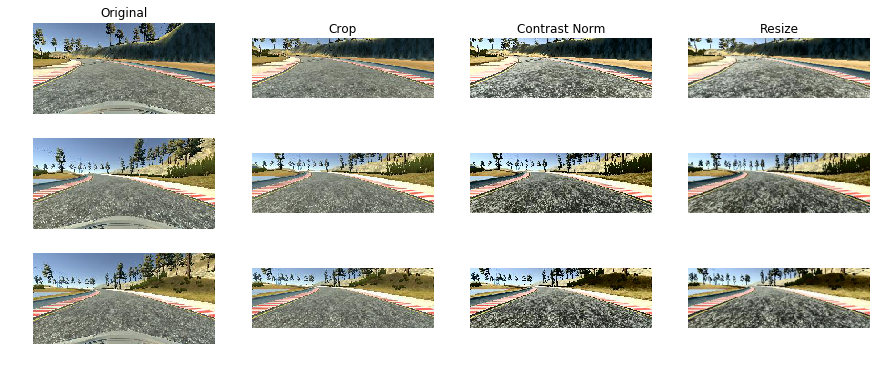

In [12]:
def display_preprocess_pipeline(images) :
    """
    Displays preprocessing pipeline for list of images
    """
    nrows = len(images)
    fig, axes = plt.subplots(nrows, 4, figsize=(15,2*nrows))
    
    # pre-processing pipeline
    pipeline = ['Original','Crop','Contrast Norm','Resize']
    
    # plot pipeline
    for ax, p in zip(axes[0,:], pipeline) :
        ax.set_title(p)
    for ax,img in zip(axes,images) :
        ax[0].imshow(img)
        img = crop_img(img)
        ax[1].imshow(img)
        img = contrast_norm(img)
        ax[2].imshow(img)
        img = resize_img(img)
        ax[3].imshow(img)
        for a in ax :
            a.axis('off')

img_list = [generate_image(random.randrange(nb_imgs)).image for i in range(3)]
display_preprocess_pipeline(img_list)

This to demonstrate preprocessing for second track with different lighting conditions. Note that this track is **not** used for training/validation in whatsoever way. 

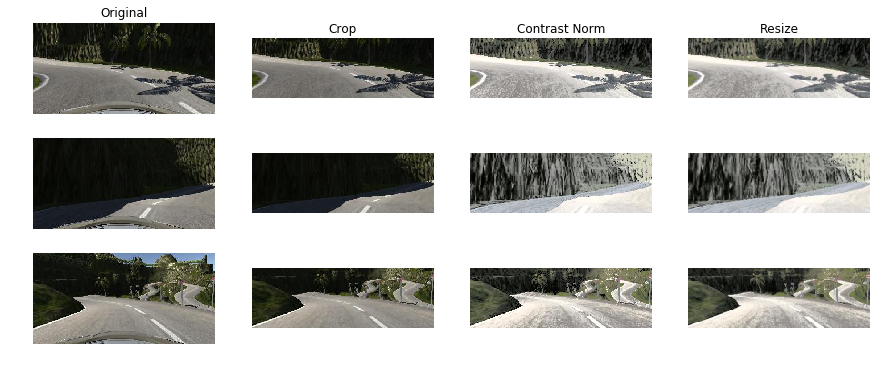

In [13]:
track2_files = glob('./myData/IMG/center_*.jpg')
n_track2 = len(track2_files)
img_list = [cv2.imread(track2_files[random.randrange(n_track2)]) for i in range(3)]
img_list = [cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in img_list]
display_preprocess_pipeline(img_list)

### Image augmentation 

Following image augmentations are performed real time during training :
* Camera selection : One of the three cameras is selected and steering angle is adjusted accordingly for training purposes. Concretely, a steering shift of +0.4 and -0.4 is included for left and right cameras respectively. This allows us to effectively treat side camera images as center camera images. This procedure allows us us to deal with the problem of biased steering angles in the dataset. 
* Flip : Images are flipped about vertical axis and the sign of steering sign is changed. This leads to better generalization for new datasets.
* Viewpoint transformation :  Using front, left and right cameras tends to generate very spicific steering angles. To augment dataset with many intermediate steering angles, we use viewpoint transformation. Although this kind of perspective transformation requires knowledge of camera and 3D information, we use a simple approximation and show that it seems to work well (see below). 

In [14]:
cam_positions = ['left','center','right']
delta_steer = {'left':0.4, 'center':0., 'right':-0.4}

# extend class for data augmentation 
class generate_image :
    def __init__(self, img_index, cam_pos='center') :
        self.img_data = data.iloc[img_index]
        self.steer = self.img_data['steering']
        self.set_camera(cam_pos)
    def reset(self) :
        self.set_camera('center')
    def set_camera(self, cam_pos) :
        self.cam_pos = cam_pos
        if cam_pos=='random' :
            self.cam_pos = random.choice(cam_positions)
        file_name = os.path.join(dataDIR,self.img_data[self.cam_pos].strip())
        img = cv2.imread(file_name)
        self.image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        self.new_steer = self.steer + delta_steer[self.cam_pos]
    def flip(self) :
        self.image = cv2.flip(self.image,1)
        self.new_steer = -self.new_steer
    def viewpoint_transform(self, shift=0.4, rotation=0.4) :
        delta1 = 70*shift/delta_steer['left'] # calibration
        delta2 = 70*rotation/delta_steer['left'] # calibration
        h,w,_ = self.image.shape
        pts1 = np.float32([[w/2-30,h/3],[w/2+30,h/3],[w/2-80,h],[w/2+80,h]])
        pts2 = np.float32([[w/2-30+delta2,h/3],[w/2+30+delta2,h/3],[w/2-80-delta1,h],[w/2+80-delta1,h]])
        M = cv2.getPerspectiveTransform(pts1,pts2)
        self.image = cv2.warpPerspective(self.image,M,(w,h))
        self.new_steer += -shift + rotation

### Viewpoint transformation 

We use two kinds of viewpoint transformations :
* Lateral shift : This perspective transformation keeps the horizon fixed while shifting the car laterally (this is the same as view from left/right cameras for fixed values of shift) . 
* Rotation : This keeps the position of the car on the road fixed while moving the horizon.  

Below we show the two viewpoint transformations in action :  

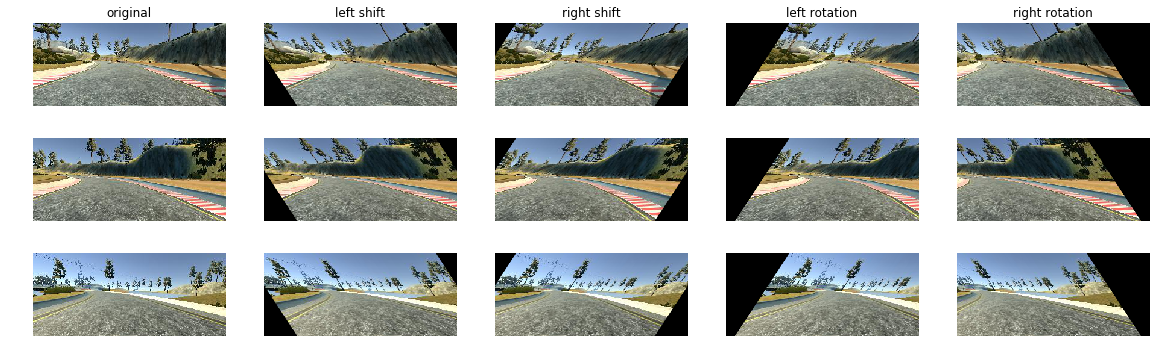

In [15]:
large_angles = data.loc[abs(data['steering'])>0.3].index.values
random.shuffle(large_angles)

img_list = large_angles[0:3]
actions = ['original', 'left shift', 'right shift', 'left rotation', 'right rotation']

n_rows = len(img_list)
n_cols = len(actions)
fig,axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*2))

for action, ax in zip(actions, axes[0,:]) :
    ax.set_title(action)
for img_index, ax in zip(img_list, axes) :
    img = generate_image(img_index, cam_pos='center')
    ax[0].imshow(img.image[:-22,:])
    #ax[0].set_title("{:.3f}".format(img.new_steer))
    img.reset()
    img.viewpoint_transform(shift=delta_steer['right'], rotation=0)
    ax[1].imshow(img.image[:-22,:])
    #ax[1].set_title("{:.3f}".format(img.new_steer))
    img.reset()
    img.viewpoint_transform(shift=delta_steer['left'], rotation=0)
    ax[2].imshow(img.image[:-22,:])
    #ax[2].set_title("{:.3f}".format(img.new_steer))
    img.reset()
    img.viewpoint_transform(shift=0, rotation=delta_steer['left'])
    ax[3].imshow(img.image[:-22,:])
    #ax[3].set_title("{:.3f}".format(img.new_steer))
    img.reset()
    img.viewpoint_transform(shift=0, rotation=delta_steer['right'])
    ax[4].imshow(img.image[:-22,:])
    #ax[4].set_title("{:.3f}".format(img.new_steer))
    for axis in ax :
        axis.axis('off')

Below, we generate images by shift viewpoint transformation on center camera to approximate left and right camera images. These are compared with the ones actually taken by left and right cameras. The approximation seems to work reasonably well!

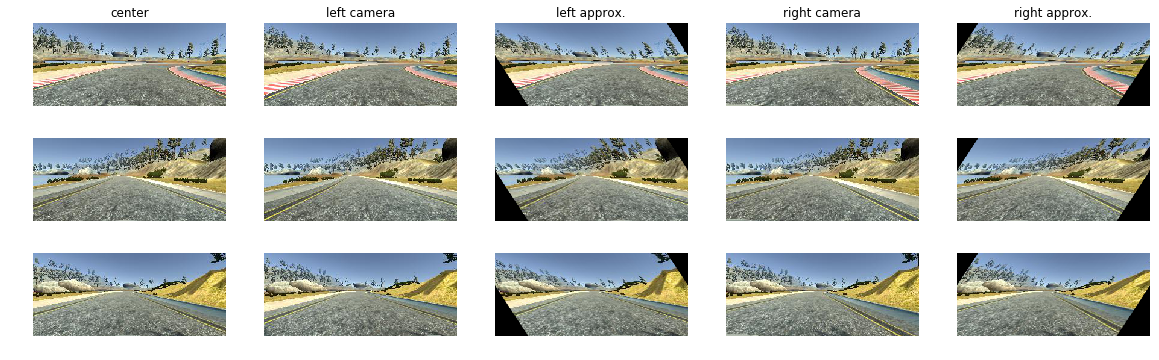

In [16]:
img_list = [random.randrange(nb_imgs) for i in range(3)]
actions = ['center', 'left camera', 'left approx.', 'right camera', 'right approx.']

n_rows = len(img_list)
n_cols = len(actions)
fig,axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*2))

for action, ax in zip(actions, axes[0,:]) :
    ax.set_title(action)
for img_index, ax in zip(img_list, axes) :
    img = generate_image(img_index, cam_pos='center')
    ax[0].imshow(img.image[:-22,:])
    img.reset()
    img.set_camera('left')
    ax[1].imshow(img.image[:-22,:])
    img.reset()
    img.viewpoint_transform(shift=delta_steer['right'], rotation=0)
    ax[2].imshow(img.image[:-22,:])
    img.reset()
    img.set_camera('right')
    ax[3].imshow(img.image[:-22,:])
    img.reset()
    img.viewpoint_transform(shift=delta_steer['left'], rotation=0)
    ax[4].imshow(img.image[:-22,:])
    for axis in ax :
        axis.axis('off')

Below we visualize each of the data augmentation operation (bottom of the images are cropped to remove car hood): 

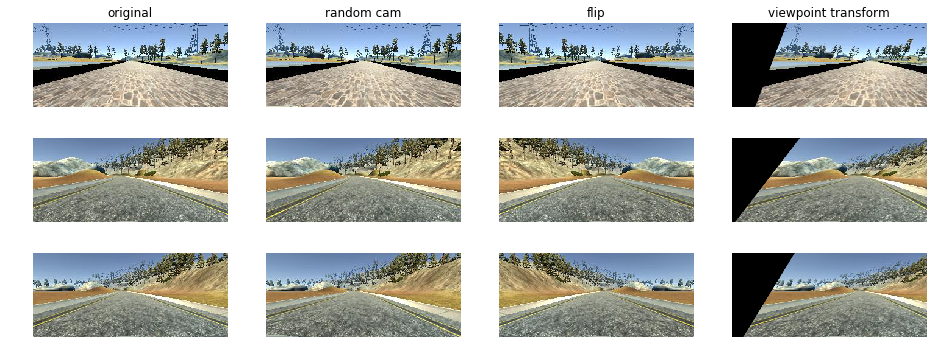

In [17]:
img_list = [random.randrange(nb_imgs) for i in range(3)]
actions = ['original', 'random cam', 'flip','viewpoint transform']

n_rows = len(img_list)
n_cols = len(actions)
fig,axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*2))

for action, ax in zip(actions, axes[0,:]) :
    ax.set_title(action)
for img_index, ax in zip(img_list, axes) :
    img = generate_image(img_index)
    ax[0].imshow(img.image[:-22,:])
    img.set_camera(cam_pos='random')
    ax[1].imshow(img.image[:-22,:])
    img.reset()
    img.flip()
    ax[2].imshow(img.image[:-22,:])
    img.reset()
    img.viewpoint_transform(shift=random.uniform(-0.4,0.4))
    ax[3].imshow(img.image[:-22,:])
    for axis in ax :
        axis.axis('off')

### Visualizing augmented images along with the adjusted steering angles :

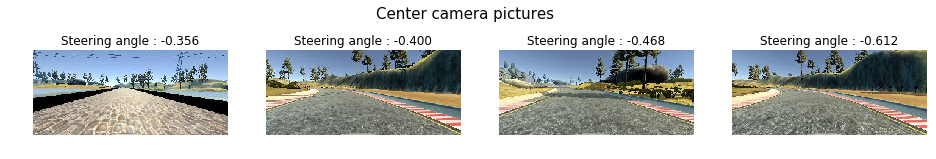

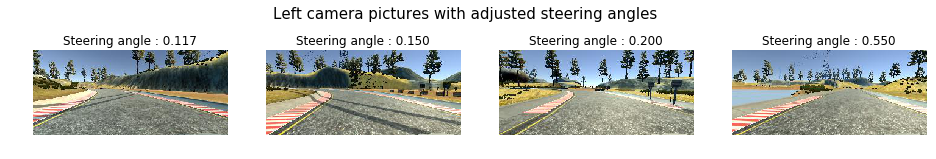

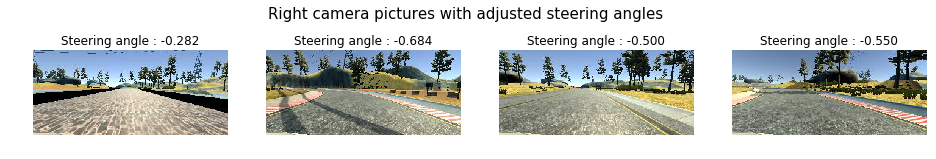

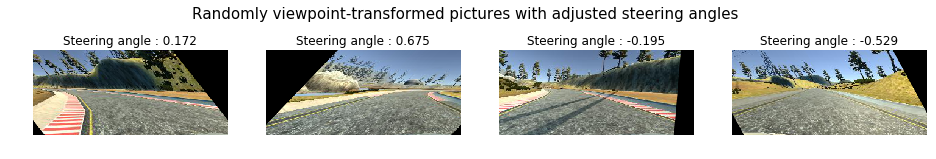

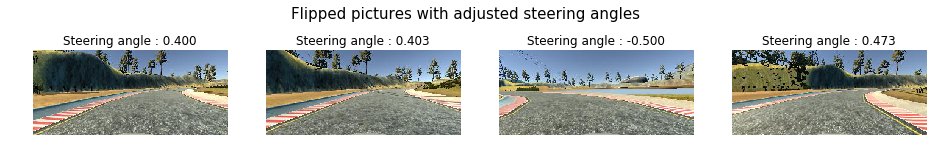

In [18]:
center_angles = data.loc[(abs(data['steering'])<0.3) & (abs(data['steering'])>=0.1)].index.values
random.shuffle(center_angles)

large_angles = data.loc[abs(data['steering'])>0.3].index.values
random.shuffle(large_angles)

ncols = 4
nrows = 1
fig, axes = plt.subplots(nrows,ncols, figsize=(4*ncols,2.5*nrows))
fig.suptitle("Center camera pictures", fontsize=15)
for ax,img_index in zip(axes.flatten(), large_angles[0:8]) :
    img = generate_image(img_index)
    ax.imshow(img.image[:-20,:])
    ax.set_title('Steering angle : {:.3f}'.format(img.new_steer))
    ax.axis('off')
fig, axes = plt.subplots(nrows,ncols, figsize=(4*ncols,2.5*nrows))
fig.suptitle("Left camera pictures with adjusted steering angles", fontsize=15)
for ax,img_index in zip(axes.flatten(), center_angles[0:8]) :
    img = generate_image(img_index, cam_pos='left')
    ax.imshow(img.image[:-20,:])
    ax.set_title('Steering angle : {:.3f}'.format(img.new_steer))
    ax.axis('off')
fig, axes = plt.subplots(nrows,ncols, figsize=(4*ncols,2.5*nrows))
fig.suptitle("Right camera pictures with adjusted steering angles", fontsize=15)
for ax,img_index in zip(axes.flatten(), center_angles[8:16]) :
    img = generate_image(img_index, cam_pos='right')
    ax.imshow(img.image[:-20,:])
    ax.set_title('Steering angle : {:.3f}'.format(img.new_steer))
    ax.axis('off')
fig, axes = plt.subplots(nrows,ncols, figsize=(4*ncols,2.5*nrows))
fig.suptitle("Randomly viewpoint-transformed pictures with adjusted steering angles", fontsize=15)
for ax,img_index in zip(axes.flatten(), center_angles[16:32]) :
    img = generate_image(img_index, cam_pos='random')
    img.viewpoint_transform(shift=random.uniform(-0.4,0.4), rotation=random.uniform(-0.4,0.4))
    ax.imshow(img.image[:-20,:])
    ax.set_title('Steering angle : {:.3f}'.format(img.new_steer))
    ax.axis('off')
fig, axes = plt.subplots(nrows,ncols, figsize=(4*ncols,2.5*nrows))
fig.suptitle("Flipped pictures with adjusted steering angles", fontsize=15)
for ax,img_index in zip(axes.flatten(), large_angles[8:16]) :
    img = generate_image(img_index)
    img.flip()
    ax.imshow(img.image[:-20,:])
    ax.set_title('Steering angle : {:.3f}'.format(img.new_steer))
    ax.axis('off')

### Image generator 

Keras requires generator for image processing. We have built a custom generator for data augmentation similar to that in Keras :

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

input_shape = (66,200,3)

class ImageGenerator :
    
    def __init__(self, data_indices, augment=False, randomize=False) :
        self.data_indices = data_indices
        self.augment=augment
        self.randomize = randomize
        self.start_index = None if self.randomize else 0
    
    # this is the generator required by Keras 
    def flow_from_dir(self, batch_size=64) :
        X_batch = np.zeros((batch_size, *input_shape))
        y_batch = np.zeros(batch_size)
        
        # infinite loop for generator 
        while True : 
            batch_indices = None
            if self.randomize :
                prob =  img_prob[self.data_indices]/np.sum(img_prob[self.data_indices])
                batch_indices = np.random.choice(self.data_indices, batch_size, p=prob) 
                #batch_indices = shuffle(self.data_indices, n_samples=batch_size)
            else :
                batch_indices = self.data_indices[self.start_index:self.start_index+batch_size]
                self.start_index += batch_size
                
                # start looping if sample exhausted
                if len(batch_indices) < batch_size :
                    diff = batch_size-len(batch_indices)
                    batch_indices += self.data_indices[0:diff]
                    self.start_index=diff          
            
            # generate images
            for i,img_index in enumerate(batch_indices) :
                img = None 
                if self.augment :
                    # generate image with random camera position
                    img = generate_image(img_index, cam_pos='random')    
                    # flip image with probability 0.5
                    if (random.choice([0,1])==0) :
                        img.flip()
                    # apply random perspective transformation 
                    img.viewpoint_transform(
                        shift=random.uniform(delta_steer['right']/2,delta_steer['left']/2),
                        rotation=random.uniform(delta_steer['right']/2,delta_steer['left']/2))  
                else :
                    img=generate_image(img_index)
                X_batch[i,:,:,:] = preprocess(img.image)
                y_batch[i] = img.new_steer
            yield (X_batch, y_batch)

Below we test our generator : 

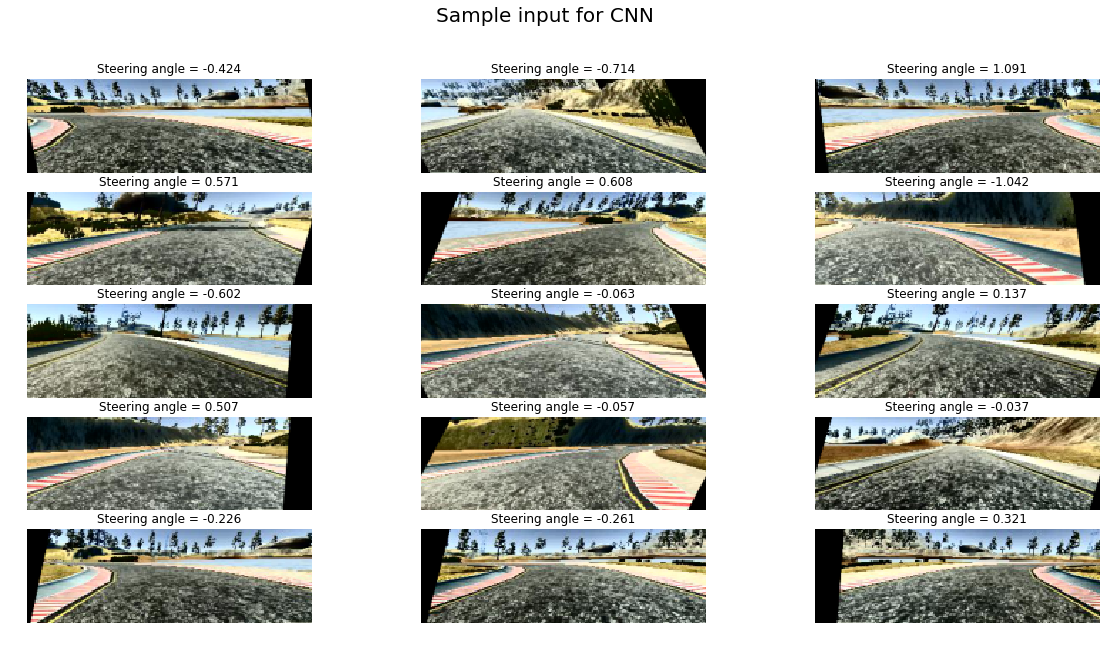

In [20]:
n_display = 15
nrows = 5
ncols = 3
test_data = ImageGenerator(list(range(nb_imgs)), randomize=True, augment=True).flow_from_dir(1)

fig, axes = plt.subplots(nrows,ncols, figsize=(20,2*nrows))
fig.suptitle("Sample input for CNN", fontsize=20)
for ax,(img,y) in zip(axes.flatten(), test_data) :
    ax.imshow(img[0])
    ax.set_title('Steering angle = {:.3f}'.format(y[0]))
    ax.axis('off')

## CNN architecture

Our architecture closely resembles NVIDIA architecture for the convolutional layers. There are five convolutional layers with 24,36,48 filters for the first three layers and 64 filters ofr the next two layers.
The first three layers use 3x3 filters with stride of 2x2 while next two layers use 3x3 filters with single stride. 
ReLU activations are used throughout. 

In [21]:
from keras.layers import Convolution2D, Dense, Activation, Flatten, Dropout
from keras.models import Sequential, load_model
input_shape = (66,200,3)

def nvidia_base() :
    model = Sequential()
    model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu', input_shape=input_shape))
    model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
    model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(Flatten())
    return model


model = nvidia_base()
model.add(Dense(250,activation='relu'))
model.add(Dense(1))
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 5, 22, 48)     43248       convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 3, 20, 64)     27712       convolution2d_3[0][0]            
___________________________________________________________________________________________

CNN architecture visulaization : 

In [22]:
#save model visulaization to disk
from keras.utils.visualize_util import plot
plot(model, show_shapes=True, to_file='misc/model.png')
plt.figure(figsize=(5,10))
img = plt.imread('misc/model.png')
plt.imshow(img)
plt.axis('off')
plt.show()

ImportError: No module named 'pydot'

In [23]:
BATCH_SIZE=64
EPOCHS=3
nb_samples = int(8000/BATCH_SIZE)*BATCH_SIZE # samples per epoch
Validate = False # whether to use validation set

nb_valid = None  # number of validation samples
training_data, validation_data=None, None

if Validate : 
    nb_valid = int(1000/BATCH_SIZE)*BATCH_SIZE  
    train_indices, valid_indices = train_test_split(list(range(nb_imgs)), test_size=nb_valid, random_state=0)
    train_generator = ImageGenerator(train_indices, augment=True, randomize=True)
    valid_generator = ImageGenerator(valid_indices)
    nb_train = len(train_indices)
    print('Number of images in training set before augmentation = {}'.format(nb_train))
    print('Number of images in validation set  = {}'.format(nb_valid))
    print('Number of images in training set before augmentation = {}'.format(nb_train))
    print('Number of images in validation set  = {}'.format(nb_valid))
    training_data=train_generator.flow_from_dir(batch_size=BATCH_SIZE)
    validation_data=valid_generator.flow_from_dir(batch_size=BATCH_SIZE)
else :
    train_generator = ImageGenerator(list(range(nb_imgs)), augment=True, randomize=True)
    training_data=train_generator.flow_from_dir(batch_size=BATCH_SIZE)

## train model
print('Training ...')
model.compile(loss='mse', optimizer='adam')
model.fit_generator(training_data, samples_per_epoch=nb_samples, nb_epoch=EPOCHS, 
                   validation_data=validation_data, nb_val_samples=nb_valid)

## save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Training ...
Epoch 1/3
8000/8000 [==============================] - 35s - loss: 0.1146      

``
Training ...
Epoch 1/3
8000/8000 [==============================] - 34s - loss: 0.1699    
Epoch 2/3
8000/8000 [==============================] - 34s - loss: 0.0821    
Epoch 3/3
8000/8000 [==============================] - 34s - loss: 0.0718    
Saved model to disk
``